# Chl-xTB

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re

import sys
sys.path.append("../src/")

import read_files
import partition_energy
import spectral_density
import absorption
import utils

In [16]:
length = 100 #ps
dt = 10 #fs

LHII = read_files.all_LHII_data(f"{length}ps_{dt}fs")

## Partition Function


$$ Z=\sum_i e^{-bE_i} $$

$$ U=\sum_i w_i E_i $$

$$ w_i = \frac{e^{-bE_i}}{Z} $$

$$ b=\frac{1}{kT} $$

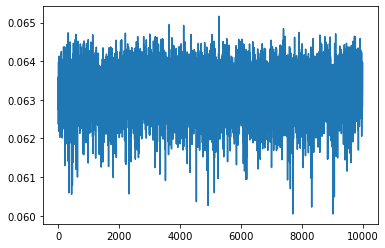

In [17]:
U = partition_energy.thermal_energy(LHII["exciton_energies"])
plt.plot(U)

## Spectral Density

In [18]:
U_rel = U - np.mean(U)
autocorr, spectrum, spectrum_normal_domain = spectral_density.spectrum_and_domain(U_rel, 10)

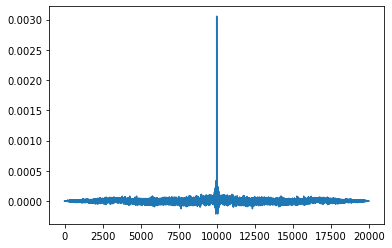

In [19]:
plt.plot(autocorr[:len(autocorr)//5])

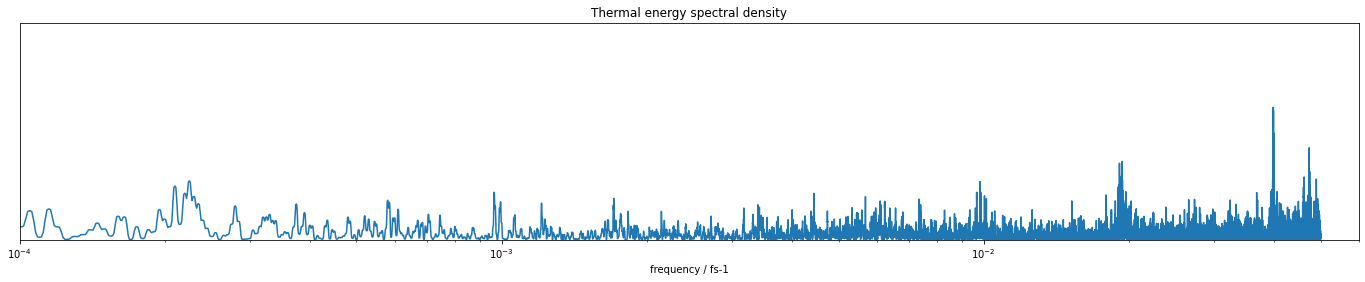

In [20]:
fig, ax = plt.subplots()

ax.plot(utils.first_half(spectrum_normal_domain), utils.first_half(np.abs(spectrum)))
ax.set_ylim(0, )

ax.set_xlim(1e-4, 6e-2)
ax.set_xscale('log')

fig.set_size_inches(24, 4)
ax.set_title("Thermal energy spectral density")
ax.set_xlabel("frequency / fs-1")
ax.set_yticks([]);

Text(0.5, 0, 'frequency / fs-1')

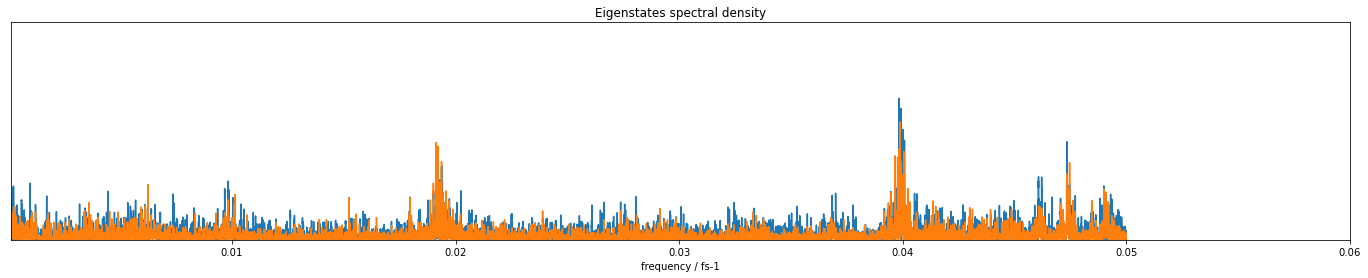

In [21]:
def spectrum_eigenstate(all_data, ax, i):
    assert(i != 0)
    diff = all_data[:,i] - all_data[:,0]
    diff_rel = diff - np.mean(diff)
    autocorr, spectrum, spectrum_normal_domain = spectral_density.spectrum_and_domain(diff_rel, 10)

    ax.plot(utils.first_half(spectrum_normal_domain), utils.first_half(np.abs(spectrum)))
    

fig, ax = plt.subplots()

spectrum_eigenstate(LHII["eigval"], ax, 1)
spectrum_eigenstate(LHII["eigval"], ax, 2)
#spectrum_eigenstate(all_data, ax, 0)

ax.set_ylim(0,)
ax.set_xlim(1e-4, 6e-2)
#ax.set_xscale('log')

ax.set_yticks([])
fig.set_size_inches(24, 4)

ax.set_title("Eigenstates spectral density")
ax.set_xlabel("frequency / fs-1")

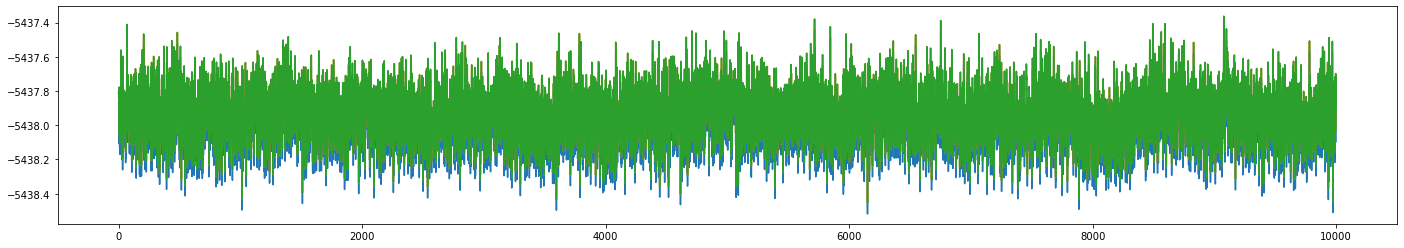

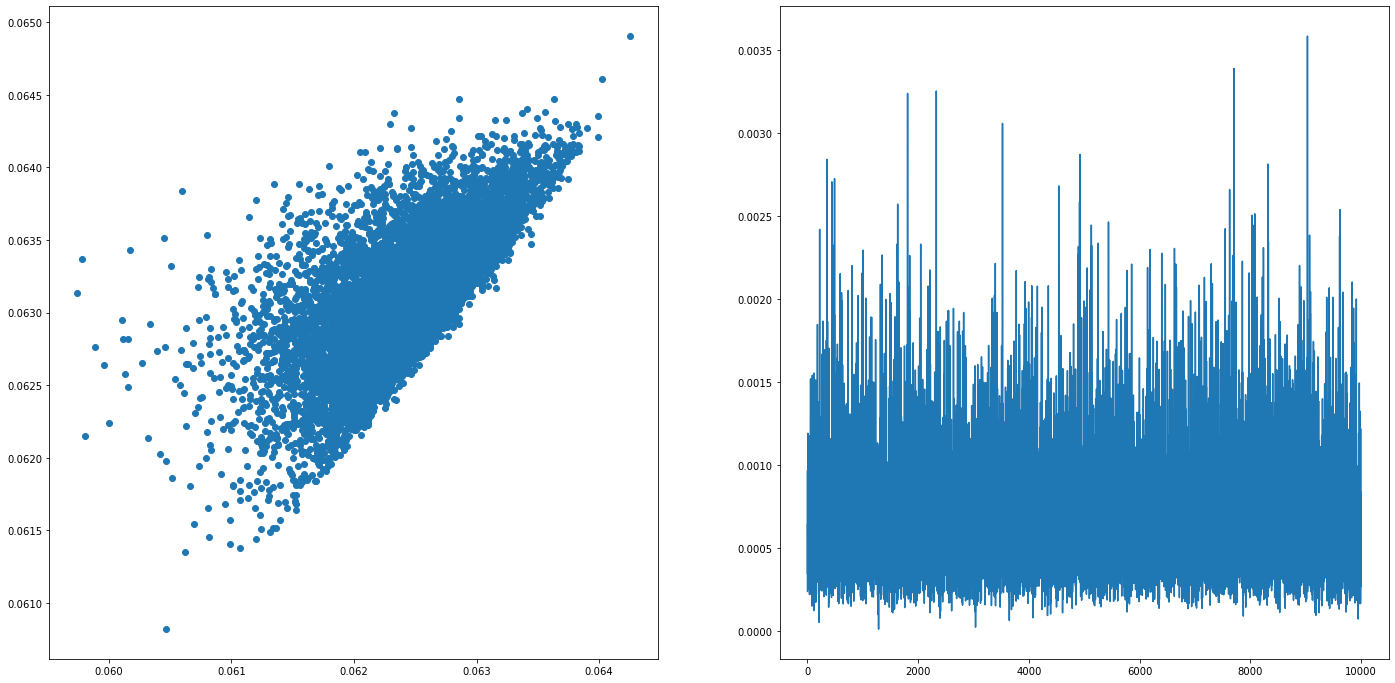

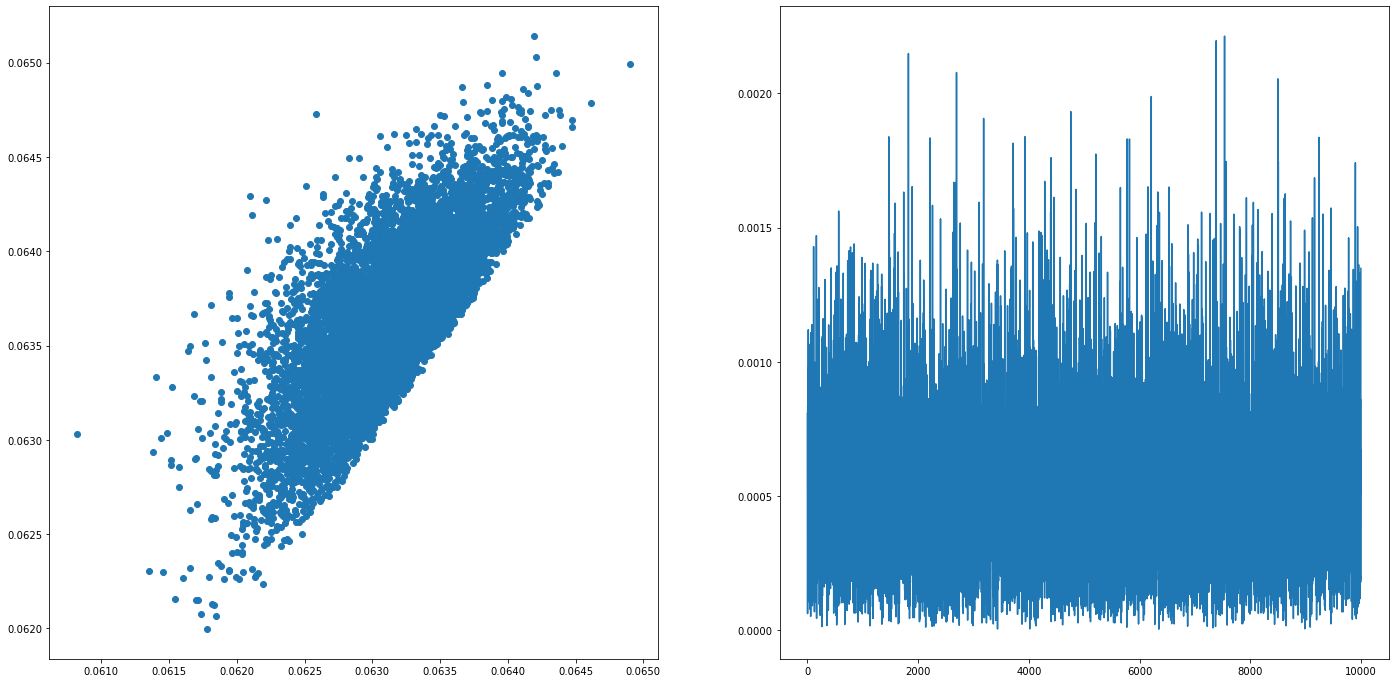

In [22]:
fig, ax = plt.subplots()

ax.plot(LHII["eigval"][:,0])
ax.plot(LHII["eigval"][:,1])
ax.plot(LHII["eigval"][:,2])

fig.set_size_inches(24, 4)


fig, ax = plt.subplots(1, 2)

ax[0].scatter(LHII["eigval"][:,1]-LHII["eigval"][:,0], LHII["eigval"][:,2]-LHII["eigval"][:,0])
ax[1].plot((LHII["eigval"][:,2]-LHII["eigval"][:,0]) - (LHII["eigval"][:,1]-LHII["eigval"][:,0]))

fig.set_size_inches(24, 12)

fig, ax = plt.subplots(1, 2)

ax[0].scatter(LHII["exciton_energies"][:, 1], LHII["exciton_energies"][:, 2])
ax[1].plot(LHII["exciton_energies"][:, 2] - LHII["exciton_energies"][:, 1])

fig.set_size_inches(24, 12)


In [23]:
time_ranges = np.ptp(LHII["eigval"], axis=1)
assert(time_ranges.shape[0] == 10000)

state_ranges = np.var(LHII["eigval"], axis=0)
assert(state_ranges.shape[0] == 28)

print(f"""
(average) range of energies along the time series : {np.mean(time_ranges):3.6f}
(average) range of energies along the state series: {np.mean(state_ranges):3.3f}
""")


(average) range of energies along the time series : 0.070881
(average) range of energies along the state series: 0.023



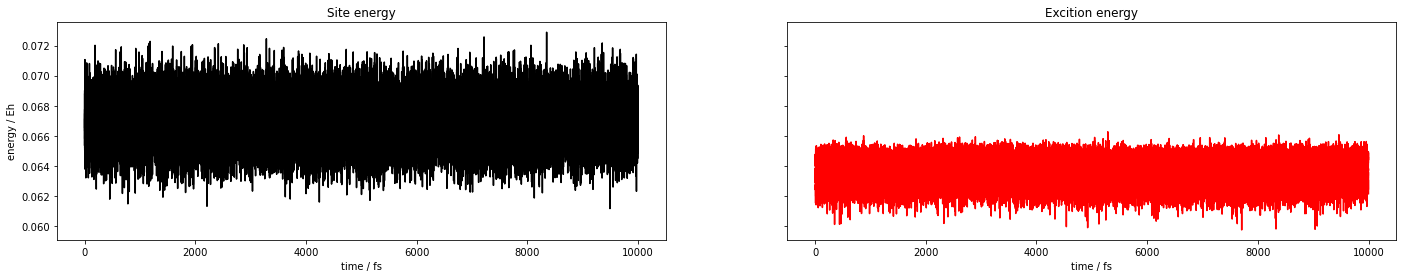

In [24]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

for i in range(0, 5):
    ax[0].plot(LHII["site_e"][:,i], color='black')
    ax[1].plot(LHII["exciton_energies"][:, i], color='red')

ax[0].set_title("Site energy")
ax[1].set_title("Excition energy")

ax[0].set_ylabel("energy / Eh")

ax[0].set_xlabel("time / fs")
ax[1].set_xlabel("time / fs")
fig.set_size_inches(24, 4)

In [25]:
#Eigenstates by probability
lights, spheres = absorption.probabilities(LHII["eigvec"], LHII["dipoles"])

Finished 'probabilities' in 99.601507 secs


In [26]:
average_sphere = np.array([np.mean(spheres[:, i]) for i in range(27)])
weight = [x/np.max(average_sphere) for x in average_sphere]
weight

[0.6398655670261323,
 1.0,
 0.9819421885808486,
 0.5114189960999229,
 0.4116836358225592,
 0.36938202309099094,
 0.3455623400450288,
 0.35259384649583153,
 0.3602425895522005,
 0.3568975611188157,
 0.3463664304527276,
 0.3439583149981148,
 0.3341372788235045,
 0.31714108197549906,
 0.30235298575289826,
 0.2817600081207302,
 0.26563140449660777,
 0.2502434072594689,
 0.2335832464588893,
 0.21865620715281944,
 0.20729620417918565,
 0.1893360610981322,
 0.17468763284976305,
 0.16563765246909343,
 0.15677408028967846,
 0.15475949120150798,
 0.1592322243787266]

26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 

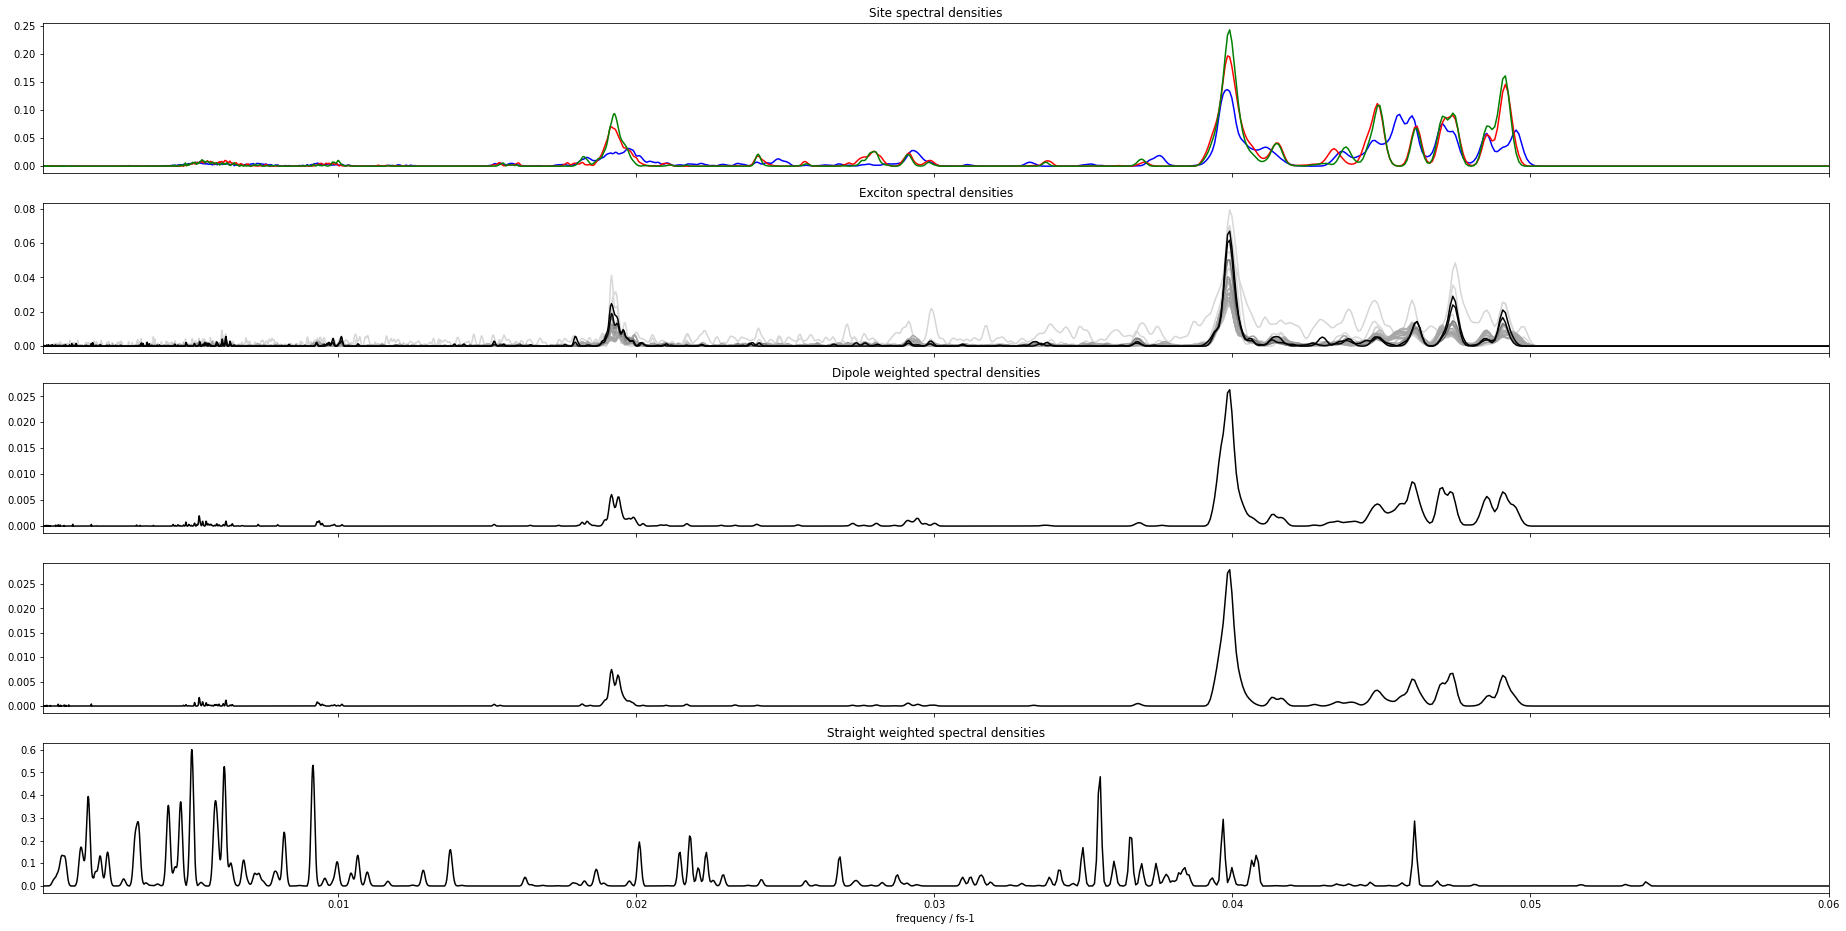

In [31]:
fig, ax = plt.subplots(5, 1, sharex=True)

start, end = 1e-4, 6e-2
num = 3500

ax[0].set_xlim(start, end)
ax[1].set_xlim(start, end)
ax[2].set_xlim(start, end)
ax[3].set_xlim(start, end)

p_range = (start, end, num)

colors=["red", "blue", "green"]

#Sites excitations
ax[0].set_title("Site spectral densities")

b850a = list(range(0, 27, 3))
b800 = list(range(1, 27, 3))
b850b = list(range(2, 27, 3))

spectral_density.broadened_average_spectral_density(LHII["site_e"], dt, ax[0], indices=b800, broadening=0.0025, p_range=p_range, color="blue")
spectral_density.broadened_average_spectral_density(LHII["site_e"], dt, ax[0], indices=b850a, broadening=0.0025, p_range=p_range, color="red")
spectral_density.broadened_average_spectral_density(LHII["site_e"], dt, ax[0], indices=b850b, broadening=0.0025, p_range=p_range, color="green")

#Exciton excitations
ax[1].set_title("Exciton spectral densities")

average_sphere = np.array([np.mean(spheres[:, i]) for i in range(27)])
weight = [x/np.max(average_sphere) for x in average_sphere]
for i in range(26, 0, -1):
    print(i, end=" ")
    spectral_density.broadened_spectral_density(LHII["exciton_energies"][:, i], dt, ax[1], 0.0025, p_range=p_range, color=f"{1-weight[i]}")


# Weighted average
avg_by_probability = np.average(LHII["exciton_energies"], axis=1, weights = spheres)
spectral_density.broadened_spectral_density(avg_by_probability, dt, ax[2], 0.0025, p_range=p_range)

ax[2].set_title("Dipole weighted spectral densities")


#Average
avg_no_weight = np.average(LHII["exciton_energies"], axis=1)
spectral_density.broadened_spectral_density(avg_no_weight, dt, ax[3], 0.0025, p_range=p_range)

ax[4].set_title("Straight weighted spectral densities")

import json
with open("../data/hessians/huang_rhys.json") as hr_json:
    res = json.load(hr_json)
    
hrfs = [res[x]["hrf"] for x in res.keys()]
wavenumbers = [res[x]["wavenumber"] for x in res.keys()]
freqs = [res[x]["frequency"] for x in res.keys()]

hrf_broadening = spectral_density.gaussians_static_broadening(hrfs, freqs, 0.00006, 0)
spectral_density.plot_gaussians(hrf_broadening, 0.6, ax[4], p_range=p_range)
ax[4].set_xlabel("frequency / fs-1")

#ax[0].set_xscale('log')
#ax[1].set_xscale('log')
#ax[2].set_xscale('log')
#ax[3].set_xscale('log')

fig.set_size_inches(32, 16)